In [1]:
import pandas as pd

df = pd.read_parquet('../data/training_data/traindf_100km.pq')
col_map = dict(zip(df.columns, range(len(df.columns))))
df.columns

Index(['fco2rec_uatm', 'sst_cci', 'sss_cci', 'pppp_hpa', 'woa_sss',
       'ncep_slp_hpa', 'dist_to_land_km', 'chl_globcolour', 'temp_soda',
       'salt_soda', 'mld_dens_soda', 'ssh_adt', 'ssh_sla', 'ice_cci'],
      dtype='object')

In [2]:
# from dataset_create.ucruise import filter_nans
# num_bins = df.index.get_level_values('bin').unique().shape[0]
# num_segments = df.index.get_level_values('segment').unique().shape[0]
# ds = df.values.reshape(len(df.columns), num_segments, num_bins)
# y = df.fco2rec_uatm.values.reshape(num_segments, num_bins)
# ds = ds[:, :, :-1]
# y = y[:, :-1]
# X, y = filter_nans(ds, y, ['sst_cci', 'sss_cci', 'chl_globcolour'], col_map)
# X.shape, y.shape


In [3]:
import numpy as np
from dataset_create.ucruise import filter_nans
# read npz file
ds = np.load('../data/training_data/trainds_100km.npy')
print(ds.shape)
y = ds[0]
# ESA-CCI > SODA 
# merge salt_soda and sss_cci, where sss_cci has priority, use salt_soda where sss_cci is nan
# salt_soda = ds[col_map['salt_soda']]
# sss_cci = ds[col_map['sss_cci']]
# mask = np.isnan(sss_cci)
# ds[col_map['sss_cci'], mask] = salt_soda[np.isnan(sss_cci)]
X, y = filter_nans(ds[:, :, :-1], y[:, :-1], ['sst_cci', 'sss_cci', 'chl_globcolour', 'mld_dens_soda'], col_map)
X.shape, y.shape

(14, 117337, 65)
Number of samples after filtering:  85202


((4, 85202, 64), (85202, 64))

In [4]:
import numpy as np
print(np.apply_along_axis(lambda x: np.isnan(x).all(), 1, y).sum())

0


[      nan       nan       nan       nan       nan       nan       nan
       nan       nan 333.822   333.237   333.5925  334.1875  336.0555
 336.152   336.7585  336.592   337.071   342.37167 342.597   340.987
       nan       nan       nan       nan       nan       nan       nan
       nan 335.0985  335.5265  335.0925  336.3115  334.5245  337.01733
       nan       nan       nan       nan       nan       nan       nan
       nan 364.835   356.336   357.6965  362.3915  365.096         nan
       nan       nan       nan 365.004         nan 357.783   356.0475
 358.416   355.3615  357.9175  357.577   355.94    355.5285  355.017
 358.5305 ]


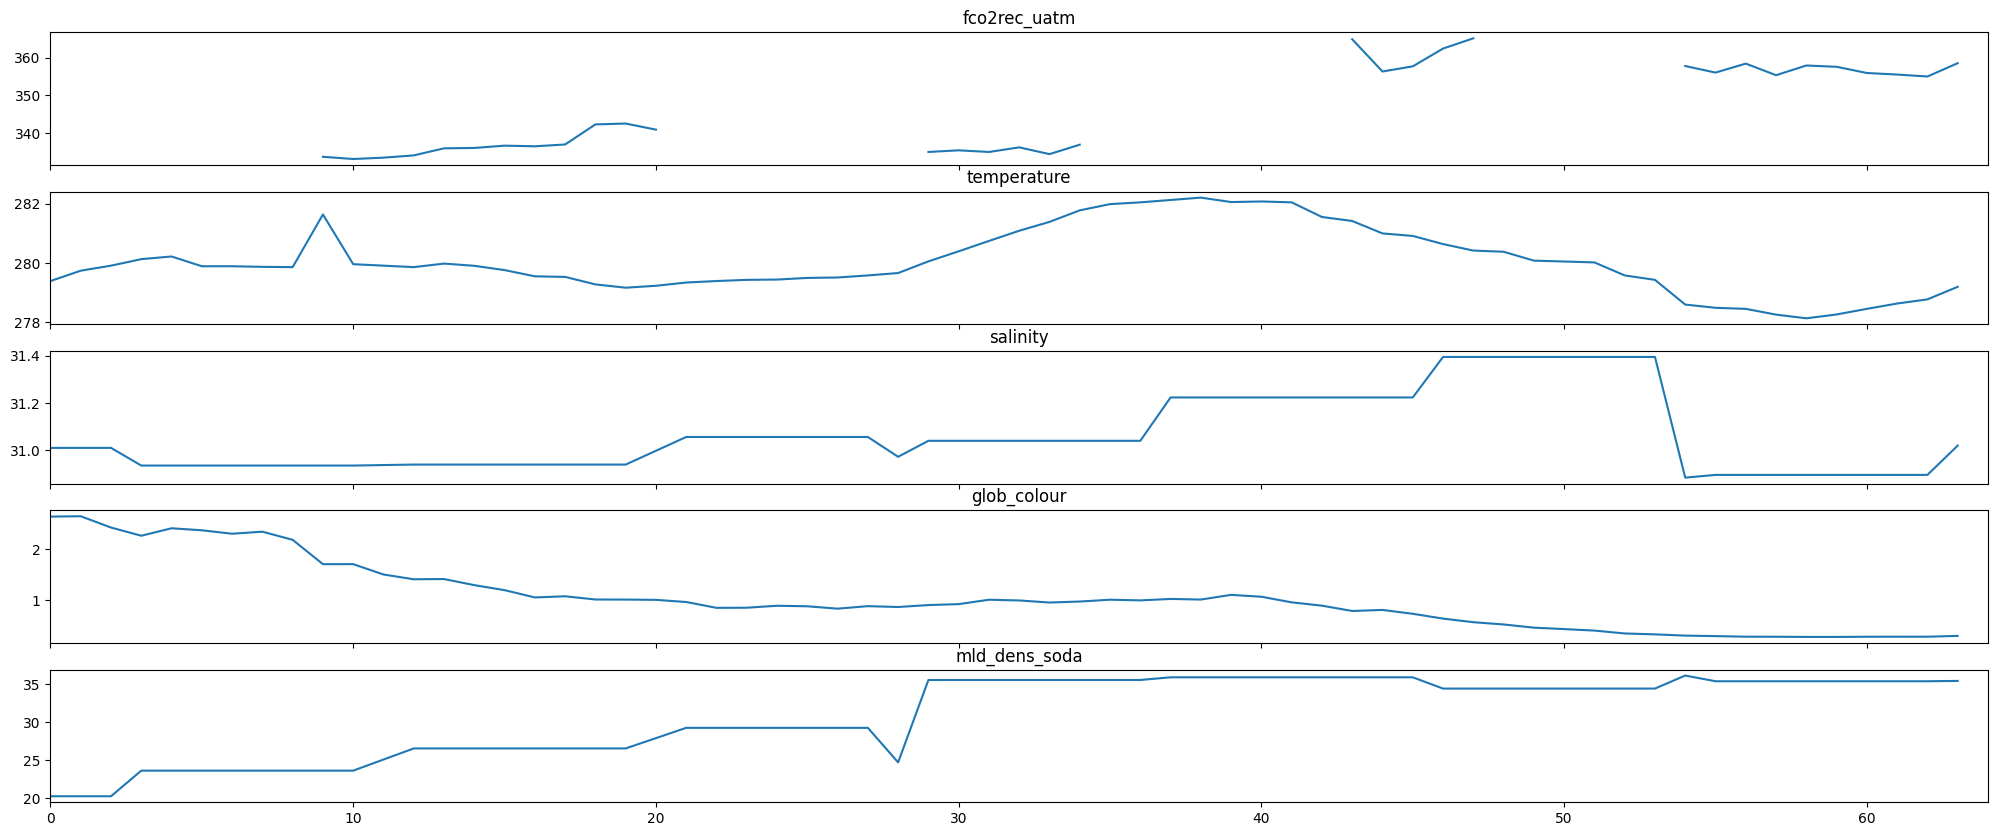

In [5]:
from dataset_create.ucruise import plot_segment
import matplotlib.pyplot as plt

plot_segment(X, y, ['fco2rec_uatm', 'temperature', 'salinity', 'glob_colour', 'mld_dens_soda'], 10000)
# print(X[0, 0, :])

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
# import wandb
from tqdm import tqdm
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler, UNet1DModel
from fco2models.utraining import train_diffusion
from torch.utils.data import TensorDataset

# fix random seed

np.random.seed(0)
torch.manual_seed(0)

print(X.shape, y[np.newaxis].shape)
assert np.isnan(X).sum() == 0
n_samples = X.shape[1]
n_dims = X.shape[2]
# print(y[:16])
ds = np.zeros((n_samples, X.shape[0] + 1, n_dims))
ds[:, 0, :] = (y - np.nanmean(y)) / np.nanstd(y)
for i in range(X.shape[0]):
    ds[:, i + 1, :] = (X[i] - X[i].mean()) / X[i].std()

print(ds.shape)
print(np.nanmean(ds[:, 0, :]), np.nanstd(ds[:, 0, :]))
# shuffle
np.random.shuffle(ds)
# split into training and validation
train_ds = ds[:int(0.9 * n_samples)]
val_ds = ds[int(0.9 * n_samples):]
train_dataset = TensorDataset(torch.from_numpy(train_ds))

(4, 85202, 64) (1, 85202, 64)
(85202, 5, 64)
6.48592236946607e-07 0.9999999059692841


In [13]:
# timestep_dim = 16
# model = UNet1DModel(sample_size=64, 
#                     in_channels= 4 + timestep_dim, 
#                     out_channels=1)
down_block_types = ["DownBlock1D", "AttnDownBlock1D"]
up_block_types = [ "AttnUpBlock1D", "UpBlock1D"]
model_params = {
    "sample_size": 64,
    "in_channels": ds.shape[1] + 1,
    "out_channels": 1,
    "layers_per_block": 3,
    "block_out_channels": (32, 64),
    "down_block_types": down_block_types,
    "up_block_types": up_block_types,
    "act_fn": "sigmoid"
}
model = UNet1DModel(**model_params)
batch_size = 128
num_epochs = 20
lr = 1e-4
timesteps = 200
model, noise_scheduler = train_diffusion(model, train_dataset, batch_size=batch_size, num_epochs=num_epochs, lr=lr, timesteps=timesteps, num_workers=4)

Training on cuda


Epoch 1/20: 100%|██████████| 600/600 [00:56<00:00, 10.66it/s, Loss=0.626]


Epoch 1 Loss: 0.710550


Epoch 2/20: 100%|██████████| 600/600 [00:53<00:00, 11.19it/s, Loss=0.648]


Epoch 2 Loss: 0.635901


Epoch 3/20: 100%|██████████| 600/600 [00:56<00:00, 10.55it/s, Loss=0.746]


Epoch 3 Loss: 0.622298


Epoch 4/20: 100%|██████████| 600/600 [00:58<00:00, 10.33it/s, Loss=0.534]


Epoch 4 Loss: 0.615936


Epoch 5/20: 100%|██████████| 600/600 [01:00<00:00,  9.98it/s, Loss=0.639]


Epoch 5 Loss: 0.611662


Epoch 6/20: 100%|██████████| 600/600 [00:58<00:00, 10.34it/s, Loss=0.582]


Epoch 6 Loss: 0.608176


Epoch 7/20: 100%|██████████| 600/600 [00:57<00:00, 10.42it/s, Loss=0.468]


Epoch 7 Loss: 0.606473


Epoch 8/20: 100%|██████████| 600/600 [00:57<00:00, 10.48it/s, Loss=0.539]


Epoch 8 Loss: 0.604891


Epoch 9/20: 100%|██████████| 600/600 [00:56<00:00, 10.54it/s, Loss=0.596]


Epoch 9 Loss: 0.601448


Epoch 10/20: 100%|██████████| 600/600 [00:58<00:00, 10.31it/s, Loss=0.524]


Epoch 10 Loss: 0.601825


Epoch 11/20: 100%|██████████| 600/600 [00:58<00:00, 10.26it/s, Loss=0.545]


Epoch 11 Loss: 0.600678


Epoch 12/20: 100%|██████████| 600/600 [00:58<00:00, 10.28it/s, Loss=0.602]


Epoch 12 Loss: 0.599307


Epoch 13/20: 100%|██████████| 600/600 [00:57<00:00, 10.48it/s, Loss=0.49] 


Epoch 13 Loss: 0.598484


Epoch 14/20: 100%|██████████| 600/600 [00:57<00:00, 10.50it/s, Loss=0.633]


Epoch 14 Loss: 0.597794


Epoch 15/20: 100%|██████████| 600/600 [00:58<00:00, 10.33it/s, Loss=0.652]


Epoch 15 Loss: 0.598606


Epoch 16/20: 100%|██████████| 600/600 [00:58<00:00, 10.24it/s, Loss=0.608]


Epoch 16 Loss: 0.598105


Epoch 17/20: 100%|██████████| 600/600 [00:57<00:00, 10.39it/s, Loss=0.592]


Epoch 17 Loss: 0.596510


Epoch 18/20: 100%|██████████| 600/600 [00:58<00:00, 10.30it/s, Loss=0.512]


Epoch 18 Loss: 0.596155


Epoch 19/20: 100%|██████████| 600/600 [00:56<00:00, 10.69it/s, Loss=0.741]


Epoch 19 Loss: 0.596995


Epoch 20/20: 100%|██████████| 600/600 [00:59<00:00, 10.04it/s, Loss=0.689]

Epoch 20 Loss: 0.595796


In [14]:
# save the model
torch.save(model.state_dict(), '../models/first/model_1d.pt')
noise_scheduler.save_config('../models/first')
# save also model hyperparameters
import json
with open('../models/first/1d_params.json', 'w') as f:
    json.dump({'batch_size': batch_size, 
               'num_epochs': num_epochs, 
               'lr': lr,
               'timesteps': timesteps,
               'model_params': model_params}, f)
# wandb.finish()
# print('done')

In [15]:
# load the model
model = UNet1DModel(**model_params)
model.load_state_dict(torch.load('../models/first/model_1d.pt'))
model.eval()
# random model
random_model = UNet1DModel(**model_params)
random_model.eval()
# load the scheduler
noise_scheduler_config = DDPMScheduler.load_config('../models/first/scheduler_config.json', local_files_only=True)
noise_scheduler = DDPMScheduler(**noise_scheduler_config)
# load also model hyperparameters
import json
with open('../models/first/1d_model_params.json', 'r') as f:
    model_params = json.load(f)

In [16]:
# find sample in validation dataset with highest mean and std
print(val_ds[:, 0, :].shape)
fco2val = val_ds[:, 0, :]
print(np.apply_along_axis(lambda row: np.isnan(row).all(), 1, fco2val).any())
means = np.nanmean(fco2val, axis=1)
stds = np.nanstd(fco2val, axis=1)
idx1 = np.nanmax(means)
idx2 = np.nanmax(stds)
idx1, idx2

(8521, 64)
False


(np.float64(8.563765900475639), np.float64(7.22348056229374))

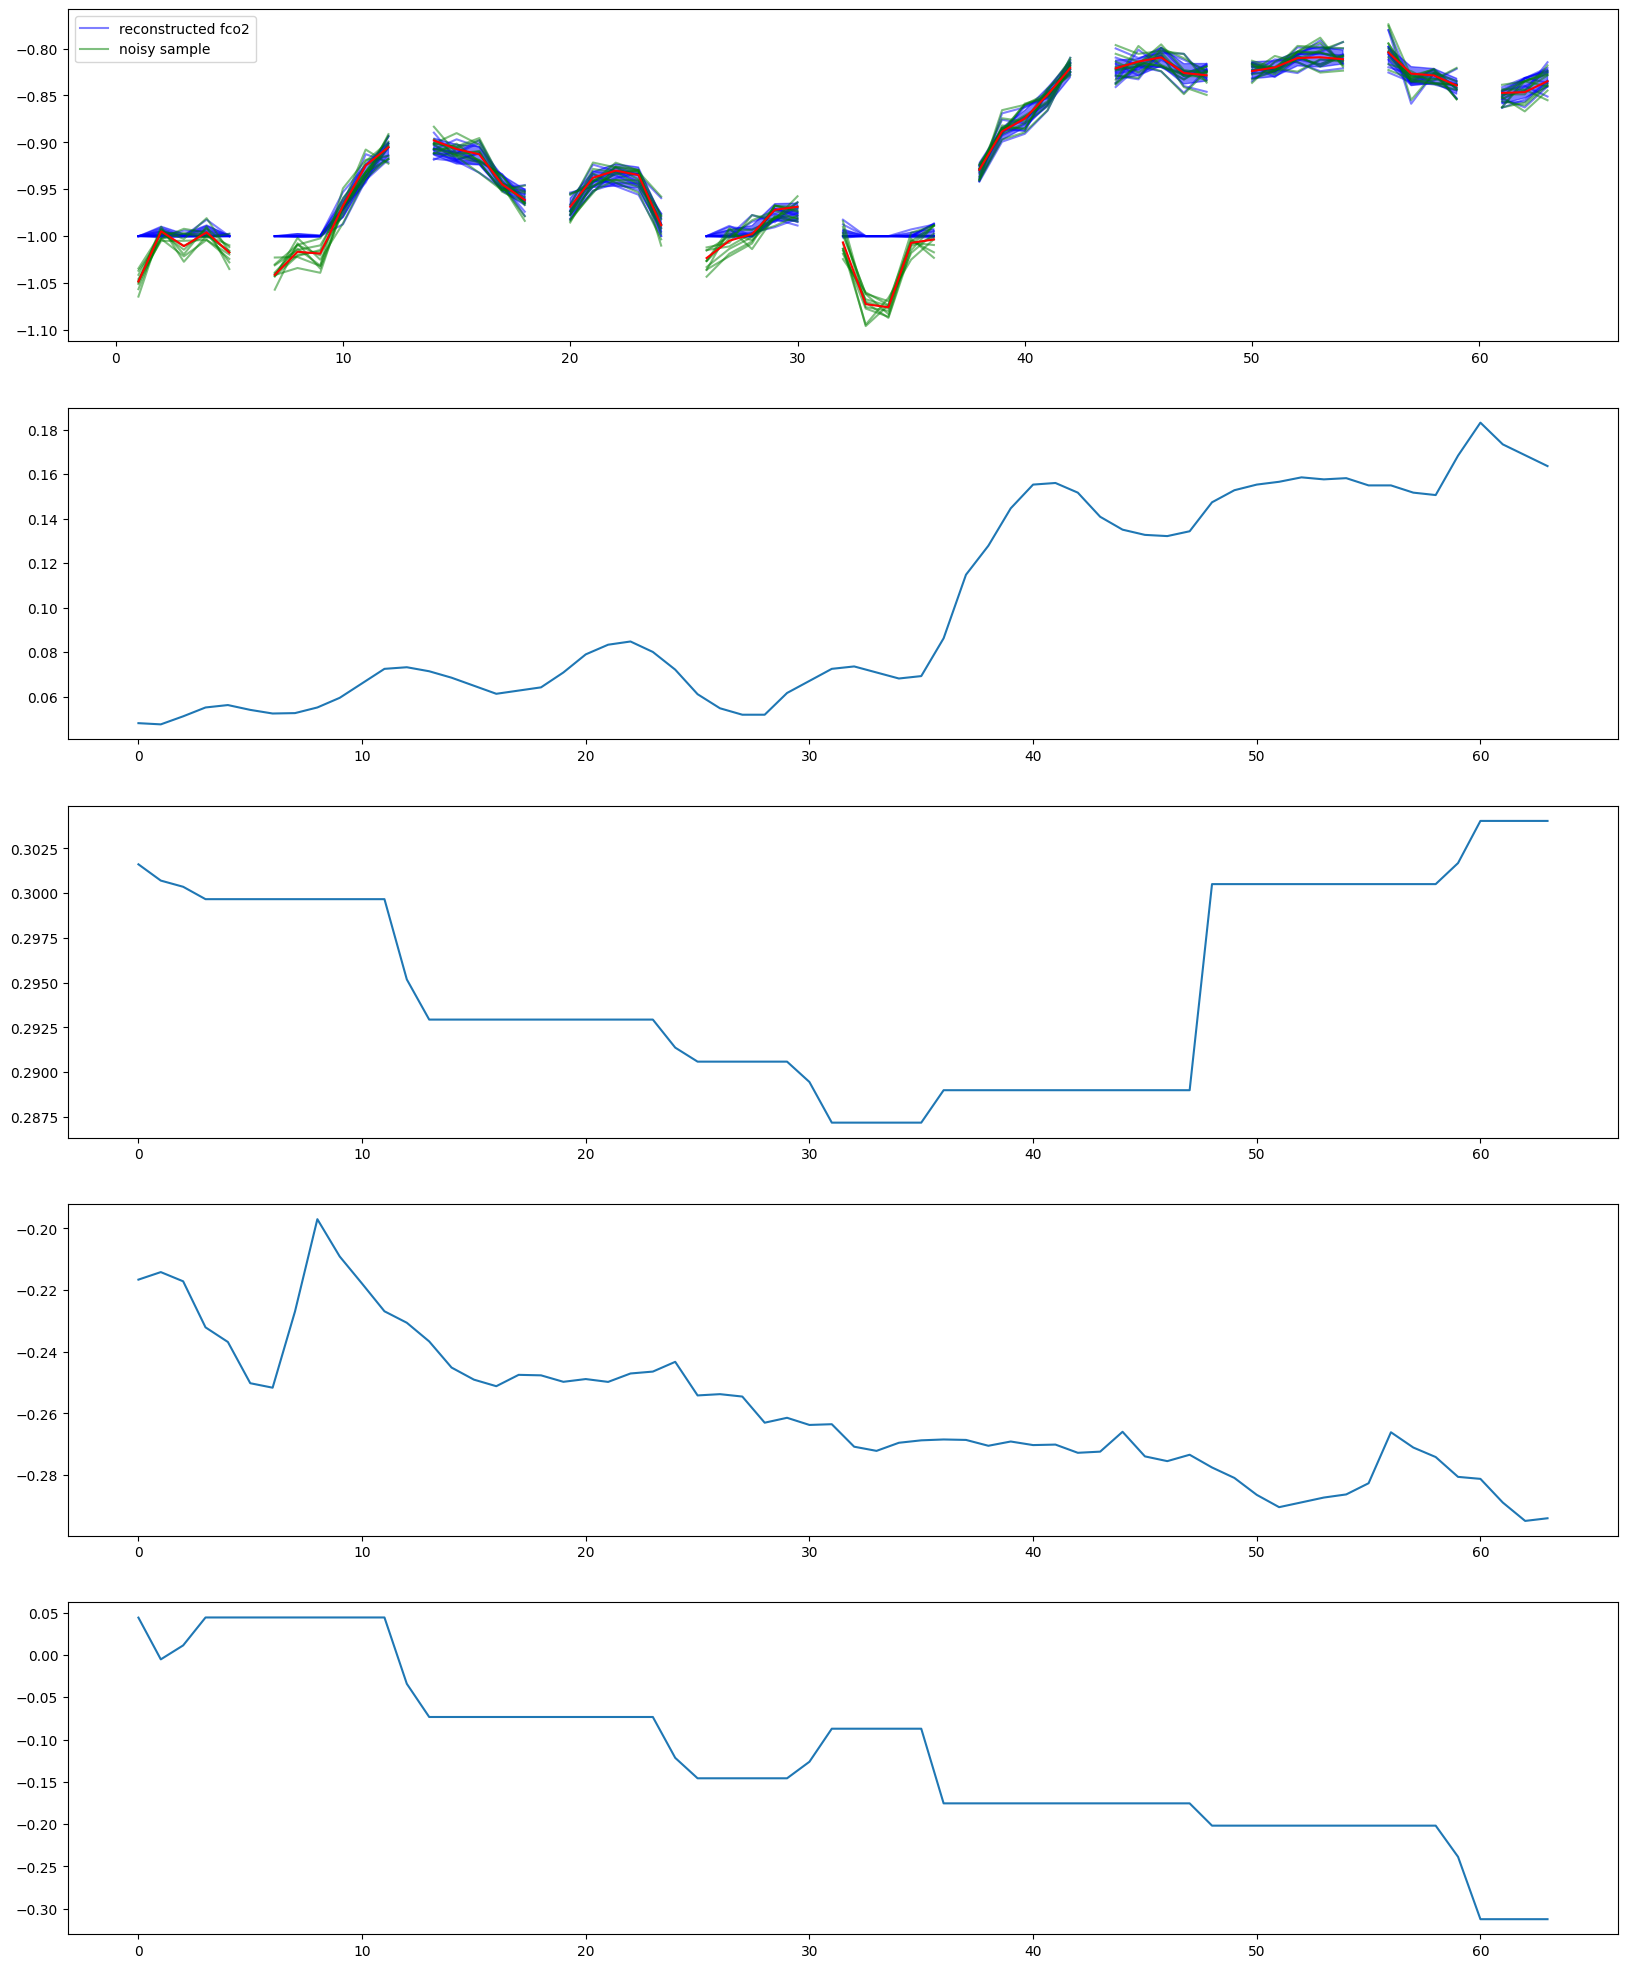

In [19]:
ix = 100
sample = torch.from_numpy(val_ds[ix, 0:1, :]).float()
nan_sample = torch.where(torch.isnan(sample), torch.zeros_like(sample), sample)
context = torch.from_numpy(val_ds[ix, 1:, :]).float()
# add nan mask to the context
nan_mask = ~torch.isnan(sample)
context = torch.cat([context, nan_mask.float()], dim=0)
timesteps = torch.tensor([0])
# sample 100 times and plot the distribution of reconstructed fco2
reconstructed_fco2s = []
reconstructed_noise = []
random = []
noisy_samples = []
for _ in range(50):
    noise = torch.randn_like(nan_sample)
    noisy_sample = noise_scheduler.add_noise(nan_sample, noise, timesteps)
    input = torch.cat([noisy_sample, context], dim=0).unsqueeze(0)
    with torch.no_grad():
        output = model(sample=input, timestep=timesteps)
        random_output = random_model(sample=input, timestep=timesteps)

    # reconstructed_fco2s.append(output[0].numpy().flatten())
    # reconstructed_fco2 = noise_scheduler.step(output[0], timesteps, )
    nan_fco2 = noise_scheduler.step(output[0], timesteps.item(), noisy_sample).pred_original_sample
    rec_fco2 = torch.where(nan_mask, nan_fco2, np.nan)
    reconstructed_fco2s.append(rec_fco2.numpy().flatten())
    nan_noisy_sample = torch.where(~nan_mask, torch.nan, noisy_sample)
    noisy_samples.append(nan_noisy_sample.numpy().flatten())
    random.append(random_output[0].numpy().flatten())

reconstructed_fco2s = np.array(reconstructed_fco2s)
random = np.array(random)
noisy_samples = np.array(noisy_samples)
fig, axs = plt.subplots(5, 1, figsize=(20, 5*5))
line01 = axs[0].plot(reconstructed_fco2s.T[:,:10], color='blue', alpha=0.5)
# plot devations from the mean
axs[0].fill_between(np.arange(0, 64), reconstructed_fco2s.mean(axis=0) - reconstructed_fco2s.std(axis=0),
                 reconstructed_fco2s.mean(axis=0) + reconstructed_fco2s.std(axis=0), color='blue', alpha=0.5)
line02 = axs[0].plot(noisy_samples.T[:,:10], color='green', alpha=0.5)
# plt.plot(random.T, color='green', alpha=0.05)
# plt.plot(reconstructed_fco2s.mean(axis=0), label='reconstructed fco2')
# plt.plot(random.mean(axis=0), label='random diffusion')
axs[0].plot(sample.flatten(), label='true fco2', color='red')
axs[0].legend(handles=[line01[0], line02[0]], labels=['reconstructed fco2', 'noisy sample'])
axs[1].plot(context[0].numpy(), label='temperature')
axs[2].plot(context[1].numpy(), label='salinity')
axs[3].plot(context[2].numpy(), label='glob colour')
axs[4].plot(context[3].numpy(), label='mld dens soda')
plt.show()
# print(reconstructed_fco2s

torch.Size([1, 3, 64])
torch.Size([1, 1, 64])
0


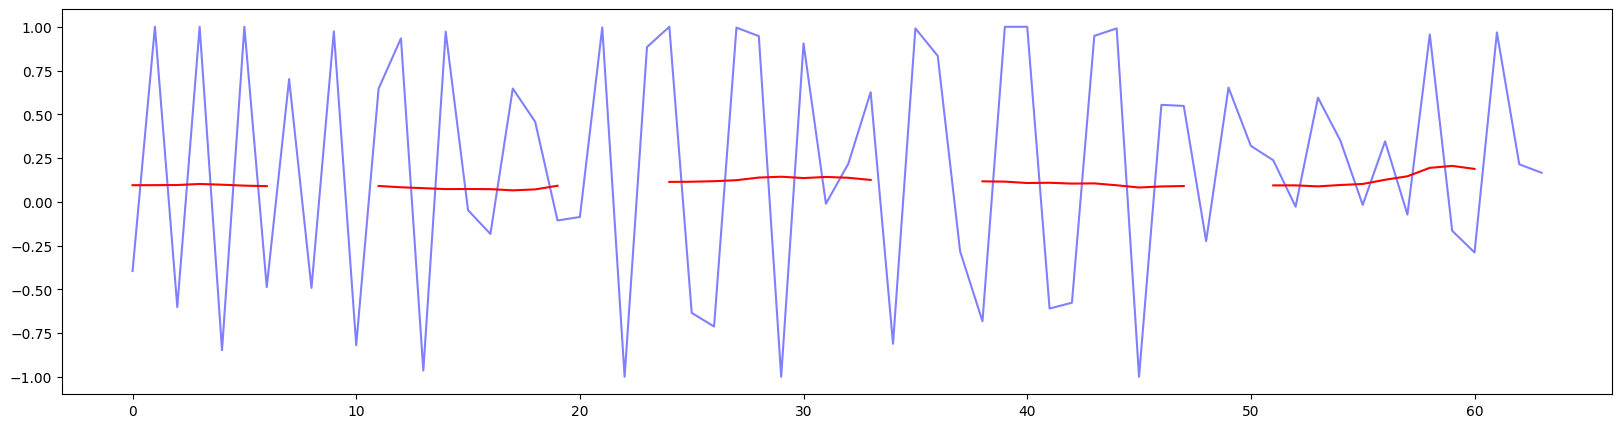

In [ ]:
ix = 0
fco2 = torch.from_numpy(val_ds[ix, 0:1, :]).float().view(1, 1, -1)
nan_sample = torch.where(torch.isnan(fco2), torch.zeros_like(fco2), fco2)
context = torch.from_numpy(val_ds[ix, 1:, :]).float().view(1, 3, -1)
print(context.shape)
print(sample.shape)

n_samples = 1
samples = []
for ix in range(n_samples):
    print(ix)
    sample = torch.randn(1, 1, 64)
    for i, t in enumerate(noise_scheduler.timesteps):
        mask = torch.ones_like(sample).bool()
        # concat noise, context and mask
        sample_context = torch.cat([sample, context, mask], dim=1)
    
        # Get model pred
        with torch.no_grad():
            residual = model(sample_context, t, return_dict=False)[0]
    
        # Update sample with step
        sample = noise_scheduler.step(residual, t, sample).prev_sample
    samples.append(sample)

samples = torch.cat(samples, dim=0)
samples = samples.squeeze(1).detach().numpy()
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.plot(samples.T, color='blue', alpha=0.5)
axs.plot(fco2.flatten(), label='true fco2', color='red')



# plot final samples